In [3]:
import numpy as np
import scipy as sp

import matplotlib.pyplot as plt
import matplotlib.axes as axe
import pandas as pd
import datetime as dt
import gurobipy as gp
from gurobipy import GRB
import cvxpy as cp

import random
from itertools import chain, combinations, tee
import time

plt.rcParams['text.usetex'] = True
# plt.rcParams['text.usetex'] = False

# Budget vs Discount - Theory

## Discount: 1 Eligible group, continuum of evenly spaced Ineligible groups

In [94]:
def y_star(ell, tau, v, lb_init = 0.0, ub_init = 2.0, y_total = 2.0, num_iters = 20):
    # Searches for y^\star satisfying ell(y^\star) + (1 - \alpha) \tau = ell(2 - y^\star)
    
    assert tau / v < ell(y_total) - ell(0.0), "We must have tau / v < ell(y_total) - ell(0.0), else is trivial."
    assert 0.0 <= alpha <= 1.0, "We must have 0.0 <= alpha <= 1.0."
    
    print("ell(lb_init) + tau / v - ell(y_total - lb_init):\n", \
          ell(lb_init) + tau / v - ell(y_total - lb_init))
    
    assert ell(lb_init) + tau / v <= ell(y_total - lb_init), \
        "We must have ell(lb_init) + tau / v <= ell(y_total - lb_init), \
        else lb_init and / or y_total is poorly defined."
    assert ell(ub_init) + tau / v >= ell(y_total - ub_init), \
        "We must have ell(ub_init) + tau / v >= ell(y_total - ub_init), \
        else ub_init and / or y_total is poorly defined."
    
    lb = lb_init
    ub = ub_init
    mid = (lb + ub)/2
    
    for k in range(num_iters):
        if ell(mid) + tau / v < ell(y_total - mid):
            lb = mid
        else:
            ub = mid
        mid = (lb + ub)/2
    
    return (lb + ub)/2
    

def yD_from_v(v_all_array, ell, tau):
    assert v_all_array.shape[0] >= 2, "there must be at least 1 bin for the eligible users, \
        and at least 1 bin for the ineligible users"
     
    v_all_array_sorted_pre_condensing = v_all_array[v_all_array[:, 0].argsort()]
    
    # TODO: Condense v_all_array_sorted_pre_condensing to avoid repeated values
    v_all_array_sorted = v_all_array_sorted_pre_condensing
    
    v_index_lb = 0
    v_index_ub = v_all_array_sorted.shape[0]-1
    v_index_mid = int(v_all_array_sorted.shape[0]/2)
    
    # Reject the case where not even the group with the highest equivalent VoT \
    # can fully occupy the express lane.
    v_max = v_all_array_sorted[-1, 0]
    y_in_of_v_max = np.sum(v_all_array_sorted[-1, 1])
    y_el_of_v_max = np.sum(v_all_array_sorted[-1, 2])
    y_of_v_max = np.sum(v_all_array_sorted[-1, 1:])

    if ell(y_of_v_max) + tau / v_max >= ell(2 - y_of_v_max):
        y_star_value = y_star(ell, tau, v_max, lb_init = 0.0, ub_init = y_of_v_max, num_iters = 20)
        assert y_star_value <= y_of_v_max, "We should have y_star_value <= y_of_v_max."
        
        y_in_expr_min = max(y_star_value - y_el_of_v_max, 0.0)
        y_in_expr_max = min(y_star_value, y_in_of_v_max)
        y_el_expr_min = max(y_star_value - y_in_of_v_max, 0.0)
        y_el_expr_max = min(y_star_value, y_el_of_v_max)
        
        return y_star_value, y_in_expr_min, y_in_expr_max, y_el_expr_min, y_el_expr_max
    
    counter = 0
    while counter == 0 or v_index_ub > v_index_lb + 1:
        v_index_mid = int((v_index_ub + v_index_lb)/2)
        v_current = v_all_array_sorted[v_index_mid, 0]

        y_current = np.sum(v_all_array_sorted[v_index_mid:, 1:])
        if ell(y_current) + tau / v_current > ell(2 - y_current):
            v_index_lb = v_index_mid
        elif ell(y_current) + tau / v_current < ell(2 - y_current):
            v_index_ub = v_index_mid
        else:
            y_star_value = np.sum(v_all_array_sorted[v_index_mid:, 1:])
            
            y_in_expr_min = np.sum(v_all_array_sorted[v_index_mid:, 1])
            y_in_expr_max = y_in_expr_min
            y_el_expr_min = np.sum(v_all_array_sorted[v_index_mid:, 2])
            y_el_expr_max = y_el_expr_min
            
            return y_star_value, y_in_expr_min, y_in_expr_max, y_el_expr_min, y_el_expr_max

        counter += 1
    
    assert v_index_ub == v_index_lb + 1, 'We should have v_index_ub == v_index_lb + 1 at this point.'

    y_star_lb = np.sum(v_all_array_sorted[v_index_ub:, 1:])
    y_star_ub = np.sum(v_all_array_sorted[v_index_lb:, 1:])
    
    print("v_index_lb:", v_index_lb)
    print("v_index_ub:", v_index_ub)
    print("y_star_lb:", y_star_lb)
    print("y_star_ub:", y_star_ub)
    print("v_all_array_sorted[v_index_lb, 0]:", v_all_array_sorted[v_index_lb, 0])
    print("ell(y_star_lb) + tau / v_all_array_sorted[v_index_lb, 0] - ell(2 - y_star_lb):", \
         ell(y_star_lb) + tau / v_all_array_sorted[v_index_lb, 0] - ell(2 - y_star_lb))

    assert ell(y_star_lb) + tau / v_all_array_sorted[v_index_ub, 0] < ell(2 - y_star_lb), \
        "We should have ell(y_star_lb) + tau / v_all_array_sorted[v_index_ub, 0] < ell(2 - y_star_lb)."
    assert ell(y_star_ub) + tau / v_all_array_sorted[v_index_lb, 0] > ell(2 - y_star_ub), \
        "We should have ell(y_star_ub) + tau / v_all_array_sorted[v_index_lb, 0] > ell(2 - y_star_ub)"

#         print("v_all_array_sorted.shape:", v_all_array_sorted.shape)
#         print("v_index_lb:", v_index_lb)

    y_star_value = y_star(ell, tau, v = v_all_array_sorted[v_index_lb, 0], \
                          lb_init = y_star_lb, ub_init = y_star_ub, num_iters = 20)

#     print("y_star_value:", y_star_value)

    assert y_star_lb < y_star_value < y_star_ub, 'We should have y_star_lb < y_star_value < y_star_ub here.'

    y_star_at_boundary = y_star_value - y_star_lb

    y_boundary_in = np.sum(v_all_array_sorted[v_index_lb, 1:])
    y_boundary_el = np.sum(v_all_array_sorted[v_index_lb, 2:])
#         y_boundary_total = np.sum(v_all_array_sorted[v_index_lb, 1:])
#         assert y_boundary_total == y_star_value - y_star_lb, "We should have \
#             y_boundary_total == y_star_value - y_star_lb here."

    y_in_expr_min = np.sum(v_all_array_sorted[v_index_ub:, 1]) + max(y_star_at_boundary - y_boundary_el, 0)
    y_in_expr_max = np.sum(v_all_array_sorted[v_index_ub:, 1]) + min(y_star_at_boundary, y_boundary_in)
    y_el_expr_min = np.sum(v_all_array_sorted[v_index_ub:, 2]) + max(y_star_at_boundary - y_boundary_in, 0)
    y_el_expr_max = np.sum(v_all_array_sorted[v_index_ub:, 2]) + min(y_star_at_boundary, y_boundary_el)
    
    return y_star_value, y_in_expr_min, y_in_expr_max, y_el_expr_min, y_el_expr_max



In [95]:
# Example 2:

t_1 = time.time()

ell = lambda x: x**4 / 16
# ell = lambda x: np.log(1 + np.exp(x))
# alpha = 0.0

# # Case 1: 
tau = 0.4
v_E = 1
v_I = 1.25

# # Case 2: 
# tau = 0.7
# v_E = 1
# v_I = 1.25

# Case 3: 
# tau = 0.7
# v_E = 1
# v_I = 2.5

# Continuum for ineligible users' VoTs (centered at v_I):
beta = 0.7
N_v_grid = 99
# N_v_grid = 1
assert 0.0 <= beta <= 1.0, "beta should be between 0.0 and 1.0"
v_I_array = np.zeros((N_v_grid, 2))
v_I_array[:, 1] = 1/N_v_grid
v_I_start = (1 - beta) * v_I + (1/(N_v_grid + 1)) * 2 * beta * v_I
v_I_end = (1 + beta) * v_I - (1/(N_v_grid + 1)) * 2 * beta * v_I
v_I_array[:, 0] = np.linspace(v_I_start, v_I_end, N_v_grid)
# print(v_I_array)

# v_all_array_setup:
## (N_v_grid x 3) array, contains equivalent (i.e., adjusted for alpha) VoTs in column 0, 
## ineligible (total) user count in column 1, and eligible (total) user count in column 2.

v_all_array_setup = np.block([v_I_array, np.zeros((N_v_grid, 1))])

# assert 0.0 > 1.0

# Compute yD curve.

num_alpha_grid_points = 500 # Should be even
alpha_vals = list(np.linspace(0, 1.0, num = num_alpha_grid_points + 1))

y_star_vals_budget = np.array(alpha_vals)
y_star_vals_discount = np.zeros(len(alpha_vals))

## To edit, below:
# y_D will be y_D_min.

# print("alpha_vals:\n\n", alpha_vals)
# print("v_all_array_setup:\n\n", v_all_array_setup)

for alpha_index, alpha_val in enumerate(alpha_vals):
    
    print("alpha_index:", alpha_index)
    print("alpha_val:", alpha_val)
    print()

    if alpha_val >= 1.0:
        # Note: May change if total eligible flow != 1.0 or total ineligible flow != 1.0
        y_D = 1.0
    elif v_E/(1 - alpha_val) > (1 + beta) * v_I:
        # Note: May change if total eligible flow != 1.0 or total ineligible flow != 1.0
        y_D = y_star(ell, tau, v = v_E / (1 - alpha_val) )
    elif v_E/(1 - alpha_val) < (1 - beta) * v_I:
        # Note: May change if total eligible flow != 1.0 or total ineligible flow != 1.0
        y_D = 0.0
    else:
        v_all_array = np.block([[v_all_array_setup], [v_E/(1 - alpha_val), 0.0, 1.0]])
#         print("v_all_array:\n\n", v_all_array)
        _, _ , _ , y_D, _ = yD_from_v(v_all_array, ell, tau)
    
    y_star_vals_discount[alpha_index] = y_D
    

# To delete below once the above is complete.        

# # y_star_zero = y_star(ell, tau, v_E, alpha = 0.0, lb_init = 0.0, ub_init = 2.0)
# # # print("y_star_zero:", y_star_zero)

# y_star_vals = np.array([y_star(ell, tau, v_E, alpha = alpha, lb_init = 0.0, ub_init = 2.0) for alpha in alpha_vals])
# # for alpha in alpha_vals:
# #     print("alpha:", alpha)
# #     y_star_temp = y_star(ell, tau, v_E, alpha = alpha, lb_init = 0.0, ub_init = 2.0)

# y_star_vals_budget = alpha_vals
# index_max = max([k for k in list(range(num_alpha_grid_points)) if alpha_vals[k] <= 1 - v_E/v_I])
# # print("index_min:", index_min)
# # print("alpha_vals[index_min]:", alpha_vals[index_min])
# # print("y_star_vals_budget:", y_star_vals_budget)
# # print()

# # print("y_star_vals:", y_star_vals)
# # print()

# y_star_vals_discount = np.copy(y_star_vals)
# for k in range(y_star_vals_discount.shape[0]):
#     if k <= index_max:
#         y_star_vals_discount[k] = 0.0

# tau_thresh_for_alpha_3 = 2 * v_E * (ell(1) - ell(1 - 1E-6)) / 1E-6
# index_for_alpha_3 = max([k for k in list(range(num_alpha_grid_points)) if y_star_vals[k] >= alpha_vals[k] ])
# alpha_3 = (y_star_vals[index_for_alpha_3] + y_star_vals[index_for_alpha_3 + 1])/2

# # print("y_star_vals_budget:", y_star_vals_budget)

# # print("y_star_vals_budget:", y_star_vals_budget)


t_2 = time.time()
print("Time:", t_2 - t_1)

alpha_index: 0
alpha_val: 0.0

v_index_lb: 50
v_index_ub: 51
y_star_lb: 0.4949494949494949
y_star_ub: 0.505050505050505
v_all_array_sorted[v_index_lb, 0]: 1.25
ell(y_star_lb) + tau / v_all_array_sorted[v_index_lb, 0] - ell(2 - y_star_lb): 0.0030616129667245806
ell(lb_init) + tau / v - ell(y_total - lb_init):
 0.0030616129667245806


AssertionError: We must have ell(lb_init) + tau / v <= ell(y_total - lb_init),         else lb_init and / or y_total is poorly defined.

Text(0, 0.5, '$\\displaystyle y^C, y^D$')

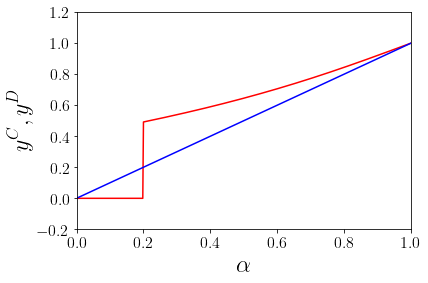

In [76]:
plt.plot(alpha_vals, y_star_vals_discount, 'red')
plt.plot(alpha_vals, y_star_vals_budget, 'blue')
# plt.scatter(alpha_vals, y_star_vals_discount, marker = 'o', s = 0.5, color = 'purple')
# plt.scatter(alpha_vals, y_star_vals_budget, marker = 'o', s = 0.5, color = 'black')
plt.xlim([0, 1.0])
plt.ylim([-0.2, 1.2])

plt.xticks(fontsize = 16)
plt.yticks(fontsize = 16)
plt.xlabel(r'$\displaystyle \alpha$', fontsize=24)
plt.ylabel(r'$\displaystyle y^C, y^D$', fontsize=24)
# plt.ylabel(r'$\displaystyle \ln(L^t - L^\star)$', fontsize=16)

In [22]:
# Example 1: Reproducing CDC 2024 paper, Fig 1 (a). \ell(x) = (1/16) * x^4, \tau = 0.4, v^E = 1, v^I = 1.25.

ell = lambda x: x**4 / 16
tau = 0.4

alpha = 0.5

v_all_array = np.array([[1.25, 1.0, 0.0], [1.0/(1-alpha), 0.0, 1.0]])

y_star_value, y_in_expr_min, y_in_expr_max, y_el_expr_min, y_el_expr_max = yD_from_v(v_all_array, ell, tau)

print("y_star_value:", y_star_value)
print("y_in_expr_min:", y_in_expr_min)
print("y_in_expr_max:", y_in_expr_max)
print("y_el_expr_min:", y_el_expr_min)
print("y_el_expr_max:", y_el_expr_max)



y_star_value: 0.6448101997375488
y_in_expr_min: 0
y_in_expr_max: 0.0
y_el_expr_min: 0.6448101997375488
y_el_expr_max: 0.6448101997375488


# Scratch Work:

In [42]:
a = np.block([[np.arange(10)], [np.arange(10)*0.5 + 2], [np.zeros(10)]]).T
index = 5

print("a:\n", a)
print()
print("a[0:index, 1:]:\n\n", a[index:, 1:])
print()
print("sum(a[0:index, 0]):", sum(a[0:index, 0]))
print(np.sum(a))

a:
 [[0.  2.  0. ]
 [1.  2.5 0. ]
 [2.  3.  0. ]
 [3.  3.5 0. ]
 [4.  4.  0. ]
 [5.  4.5 0. ]
 [6.  5.  0. ]
 [7.  5.5 0. ]
 [8.  6.  0. ]
 [9.  6.5 0. ]]

a[0:index, 1:]:

 [[4.5 0. ]
 [5.  0. ]
 [5.5 0. ]
 [6.  0. ]
 [6.5 0. ]]

sum(a[0:index, 0]): 10.0
87.5
